In [1]:
!pip install einops

import numpy as np
import pandas as pd
from tqdm import tqdm, trange #for real time progress

import re
import cv2
import os
import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import pickle
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from einops import rearrange,repeat
from einops.layers.torch import Rearrange

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.8 MB/s eta 0:00:00


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    print("GPU device name:", tf.test.gpu_device_name())
else:
    print("GPU is NOT available")

if tf.config.list_logical_devices('TPU'):
    print("TPU is available")
    tpu_name = tf.config.list_logical_devices('TPU')[0].name
    print("TPU device name:", tpu_name)
else:
    print("TPU is NOT available")

GPU is available
GPU device name: /device:GPU:0
TPU is NOT available


In [3]:
captions_link = '/kaggle/input/coco-2017-dataset/coco2017/annotations'
train_inp_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

In [4]:
captions_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
with open(captions_path,'r') as f:
    data = json.load(f)

In [5]:
# list(list(list(train_data.items())[2]))[0:2]
#images->license, file_name, coco_url, height, width, date_captured, flicker_url, id

print(type(data))
print(data['annotations'][9])

<class 'dict'>
{'image_id': 16977, 'id': 185, 'caption': 'two cars parked on the sidewalk on the street'}


In [6]:
data_df = pd.json_normalize(data, "annotations")
data_df['image_id'] = data_df['image_id'].apply(lambda x: "{:012}".format(x))
#Each caption of each image present at separtae column so total height=5*no. of images

In [7]:
data_df

,image_id,id,caption
0,000000203564,37,A bicycle replica with a clock as the front wh...
1,000000322141,49,A room with blue walls and a white sink and door.
2,000000016977,89,A car that seems to be parked illegally behind...
3,000000106140,98,A large passenger airplane flying through the ...
4,000000106140,101,There is a GOL plane taking off in a partly cl...
...,...,...,...
591748,000000133071,829655,a slice of bread is covered with a sour cream ...
591749,000000410182,829658,A long plate hold some fries with some sliders...
591750,000000180285,829665,Two women sit and pose with stuffed animals.
591751,000000133071,829693,White Plate with a lot of guacamole and an ext...


In [8]:
data_df.at[32169, 'caption'] #checking a random caption whether it loads

'A small group of sheep laying next to a guarded tree'

In [9]:
data_df['image_path'] = data_df["image_id"].apply(
    lambda x: os.path.join(train_inp_path, x)
)
data_df['image_path']=data_df['image_path']+'.jpg'

In [10]:
data_df.at[751, 'image_path']

'/kaggle/input/coco-2017-dataset/coco2017/train2017/000000124766.jpg'

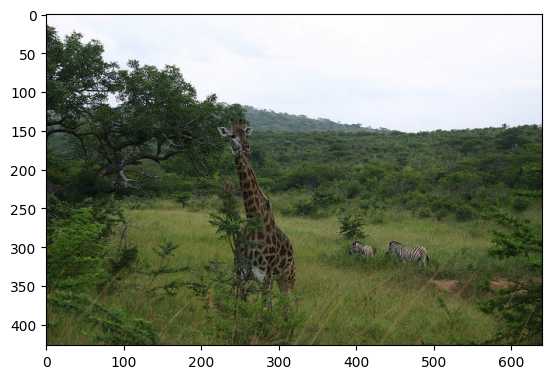

In [11]:
ia=cv2.imread(str(data_df.at[47857, 'image_path']))
plt.imshow(cv2.cvtColor(ia, cv2.COLOR_BGR2RGB))

In [12]:
# unique_elements = data_df['image_path'].unique()
# unique_list = unique_elements.tolist()

# img = np.empty((int(len(unique_list)/25), 224, 224, 3), dtype=np.uint8)

# for i in range(int(len(unique_list)/25)):
#     image_path = unique_list[i]
#     img[i] = cv2.resize(cv2.imread(str(image_path)), (224, 224))
#     if(i%500==0):
#         print("Iterations Done : ", i)

# print(i)

In [13]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# sent_x = 'sosent ' + data_df["caption"][0:img.shape[0]] + ' eosent'

# tokenizer = Tokenizer()

# tokenizer.fit_on_texts(sent_x)

# seq = tokenizer.texts_to_sequences(sent_x)

# max_sent_len = max(len(s) for s in seq)

# padded_sentences = pad_sequences(seq, maxlen=max_sent_len, padding='post')

# # for i in range(padded_sentences.shape[0]):
# #     padded_sentences[i][28]='-1'

# vocab_size = len(tokenizer.word_index) + 1

# print("Padded Sequences (padded_sentences):", padded_sentences)
# print("Vocabulary Size:", vocab_size)


In [14]:
# print(type(seq))
# print(type(padded_sentences))
# print(type(vocab_size))
# print(padded_sentences.shape)

In [15]:
# reverse_map = {ind: w for w, ind in tokenizer.word_index.items()}

# def decode_sequence(seq):
#     return str([reverse_map.get(i, '_') for i in seq])

In [16]:
# test_id=809
# print("Actual Caption : ", data_df["caption"][test_id])
# print("Decoded Caption : ", decode_sequence(padded_sentences[test_id]))

In [17]:
# padded_sentences[809]

In [18]:
# x = padded_sentences
# x = tf.expand_dims(x, axis=0)
# x = tf.squeeze(x)
# x.shape

In [19]:
# y = np.zeros_like(x)
# y.shape

In [20]:
# from tensorflow.keras.layers import Embedding

# embedding_layer = Embedding(input_dim=1, output_dim=256)
# emb_x = embedding_layer(x)

# # emb_x = tf.expand_dims(emb_x, axis=0)
# emb_x = tf.squeeze(emb_x)
# emb_x.shape

In [21]:
# emb_x=torch.tensor(emb_x.numpy()).transpose(1, 2)
# emb_x.shape

In [22]:
train_df = data_df[:5000]
train_df = train_df.sample(frac=1, random_state=30).reset_index(drop=True)
captions = train_df['caption'].tolist()
captions = ["<SOS> " + caption + " <EOS>" for caption in captions]

In [23]:
# captions

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

sequences = tokenizer.texts_to_sequences(captions)


max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

padded_sequences[0]


Vocabulary Size: 3410


array([  2,   1,  10,   4,   1,  17,  14,   9,  12, 175, 106,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
import torchvision.transforms as transforms
from PIL import Image

def load_images(image_paths, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image_tensors = []
    
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image)  
        image_tensors.append(image_tensor)
    
    image_batch_tensor = torch.stack(image_tensors)
    
    return image_batch_tensor


In [28]:
image_paths = train_df['image_path'].to_list()
images = load_images(image_paths)


In [43]:
images.shape #(batch, 3, 224, 224)


torch.Size([5000, 3, 224, 224])

# ViT

## Patchify and positional encoding

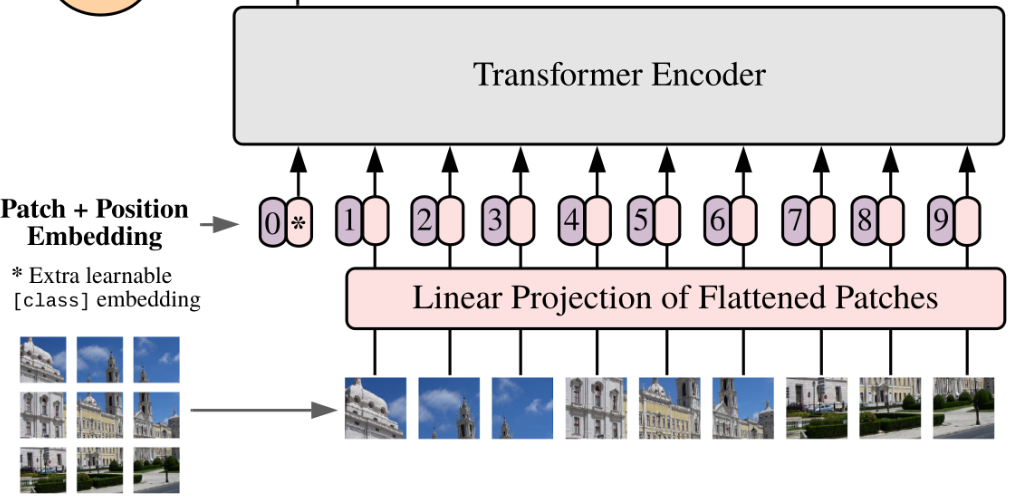
- step1 : cut the input image into patches

- Each patch goes through a linear embedding. From then on, each patch is just a one-dimensional vector.

- A positional embedding is then added to these vectors (tokens)

final output is a sequence of 197 embeddings (196 for patches and 1 for the class token), each of dimensionality emb_size (768).

In [30]:
import torch
import torch.nn as nn

In [44]:
'''
    x is the input tensor with shape (batch_size, in_channels, img_size, img_size)
    ps = 16, img_size = 224 so 224/16 * 224/ 16 = 14 * 14 patches are generated 
    Each patch is then flattened into embed size using rearrange
'''
# embed size = num_patches_w * num_patches_h * 3

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 16, embed_size = 768, img_size = 224):
        super(PatchEmbedding, self).__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embed_size = embed_size
        self.img_size = img_size
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(self.in_channels, self.embed_size, kernel_size = self.patch_size, stride = self.patch_size), #o/p shape = (batch_size, emb_size, 14, 14)
            Rearrange('b e (h) (w) -> b (h w) e'),                  # 4d tensor to 3d tensor. output shape = (batch_size, 14*14, emb_size) 
        )
        
        # learnable params
        self.cls_token = nn.Parameter(torch.randn(1,1, self.embed_size)) 
        self.positions = nn.Parameter(torch.randn((self.img_size // self.patch_size) **2 + 1, self.embed_size))  # +1 for cls token position
        
        assert self.img_size % self.patch_size == 0, "patch size must be divisible by image size"

        
    def forward(self, x) :
        b, _, _, _ = x.shape            # x: (batch_size, 3, 224, 224)
        x = self.projection(x)          # x shape after projection : (batch_size, num_patches_h *num_patches_w, embed_size) 

        # expand the cls token to match batch size. new shape of cls = (batch_size, 1, embed_size)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) 
        # prepend the cls token to the input 
        x = torch.cat([cls_tokens, x], dim=1) 
        # add position embedding
        x += self.positions   #shape = (batch_size, 14 * 14 + 1, embed_size )
        return x


## Transformer Encoder

In [45]:
import torch
import torch.nn as nn
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert self.head_dim * self.heads == self.embed_size,"Embed size must be divisible by heads"

        # Linear projections for query, key, and value
        self.qkv_projection = nn.Linear(embed_size, 3 * self.embed_size)

        self.out = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, x, mask=None):
        batch_size, sequence_length, _ = x.size()

        # Project query, key, and value
        qkv = self.qkv_projection(x).reshape(batch_size, sequence_length, self.heads, self.head_dim * 3)
        query, key, value = qkv.split(self.head_dim, dim=-1)

        # Calculate attention scores
        attention_scores = torch.einsum("nqhd,nkhd->nhqk", query, key)
        attention_scores = attention_scores / math.sqrt(self.head_dim)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

        # Apply softmax
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # Calculate weighted sum of values
        attention_output = torch.einsum("nhqk,nlhd->nqhd", attention_probs, value)
        attention_output = attention_output.view(batch_size, sequence_length, self.embed_size)

        attention_output = self.out(attention_output)

        return attention_output

## Feedforward

In [46]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)


    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [47]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, hidden_size, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(embed_size, heads)  
        self.norm1 = nn.LayerNorm(embed_size)
        self.ffn = FeedForward(embed_size, hidden_size, embed_size, dropout)
        self.norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        attn_output = self.attention(x)
        x = x + self.norm1(attn_output)
        x = x + self.norm2(self.ffn(x))
        return x

## encoder

In [48]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embed_size, heads, hidden_size, dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([TransformerBlock(embed_size, heads, hidden_size, dropout) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Passing the patches embeddings into encoder 

In [41]:
# class ViT(nn.Module):
#     def __init__(self, num_layers, embed_size, heads, hidden_size, dropout):
#         super(ViT, self).__init__()
#         self.patchEmbedding = PatchEmbedding()
#         self.encoder = Encoder(num_layers, embed_size, heads, hidden_size, dropout)
        
#     def forward(self, x):
# #         x = (batch_size, channels, H, W)
#         patchEmbeddings = self.patchEmbedding(x) # new shape = (batch_size, num_patches + 1, embed_size)
#         encoded_vectors = self.encoder(patchEmbeddings) # (batch_size, num_patches + 1, embed_size)
#         return encoded_vectors
        

In [42]:
# embed_size = 768 #16*16*3
# batch_size = 6
# num_layers = 5 #no. of times encoder block is repeated b4 feeding to decoder
# heads = 4
# hidden_size = 256
# dropout = 0.4
# num_patches = 197
# img_size = 224 
# in_channels = 3

# x = torch.randn(batch_size, in_channels, img_size, img_size)

# my_ViT = ViT(num_layers, embed_size, heads, hidden_size, dropout)  
# ViT_embeddings = my_ViT(x)
# print(ViT_embeddings.shape)
# print(ViT_embeddings)

# Transformer Decoder

## causal self attention

In [49]:
'''The CausalSelfAttnBlock implements causal self-attention, allowing each token to attend only to previous tokens (and itself) in the sequence'''

class CausalSelfAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(CausalSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = self.embed_size // self.heads
#         self.epsilon_stabilizer = epsilon_stabilizer
        self.dropout = dropout
        
        assert self.head_dim * self.heads == self.embed_size,"Embed size must be divisible by heads"
        
        self.qkv_projection = nn.Linear(embed_size, 3 * self.embed_size)
        self.out = nn.Linear(self.embed_size, self.embed_size)
        self.layer_norm = nn.LayerNorm(normalized_shape = self.embed_size) #normalise across embedding dimension
        self.attn_dropout = nn.Dropout(p = self.dropout)
        
        
#     def _safe_softmax(self, x: torch.Tensor) -> torch.Tensor:
#         num = torch.exp(x)
#         denom = torch.exp(x).sum(dim=-1, keepdims=True) + self.epsilon_stabilize
#         return num/denom
     
    def forward(self, x, mask = None):
#             print(x.shape)  

            batch_size, sequence_length, _ = x.size()
            # Project query, key, and value
            qkv = self.qkv_projection(x).reshape(batch_size, sequence_length, self.heads, self.head_dim * 3)
            query, key, value = qkv.split(self.head_dim, dim=-1)
            
            # Calculate attention scores
            attention_scores = torch.einsum("nqhd,nkhd->nhqk", query, key)
            attention_scores = attention_scores / math.sqrt(self.head_dim)
            
            # Causal Mask: Ensure that each position can only attend to itself and the previous positions
            # lower triangular matrix using "tril"
            if mask is None:
                mask = torch.tril(torch.ones(sequence_length, sequence_length)).expand(batch_size, self.heads, -1, -1).to(x.device)

            # masking i.e set attention scores to -inf where mask == 0
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

            # Apply softmax
            attention_probs = nn.functional.softmax(attention_scores, dim=-1)

            # Calculate weighted sum of values
            attention_output = torch.einsum("nhqk,nkhd->nqhd", attention_probs, value)
            # reshape            
            attention_output = attention_output.contiguous().view(batch_size, sequence_length, self.embed_size)

            attention_output = self.out(attention_output)

            return attention_output


## Cross attention block

In [50]:
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = self.embed_size // self.heads
        self.dropout = dropout
        
        assert self.head_dim * self.heads == self.embed_size, "Embed size must be divisible by heads"
        
        self.q_projection = nn.Linear(embed_size, self.embed_size)
        self.kv_projection = nn.Linear(embed_size, 2 * self.embed_size)
        self.out = nn.Linear(self.embed_size, self.embed_size)
#         self.attn_dropout = nn.Dropout(p=self.dropout)
        
    def forward(self, x, encoder_output, mask=None):
        batch_size, sequence_length, _ = x.size()
        _, enc_seq_len, _ = encoder_output.size()

        queries = self.q_projection(x)
        k_v = self.kv_projection(encoder_output).reshape(batch_size, enc_seq_len, self.heads, self.head_dim * 2)
        keys, values = k_v.split(self.head_dim, dim=-1)
        
        queries = queries.reshape(batch_size, sequence_length, self.heads, self.head_dim)
        keys = keys.reshape(batch_size, enc_seq_len, self.heads, self.head_dim)
        values = values.reshape(batch_size, enc_seq_len, self.heads, self.head_dim)

        attention_scores = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
        attention_scores = attention_scores / math.sqrt(self.head_dim)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))


        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
#         attention_probs = self.attn_dropout(attention_probs)
#         print(attention_probs.shape)
#         print(values.shape)
        

        attention_output = torch.einsum("nhqk,nkhd->nqhd", attention_probs, values)
        attention_output = attention_output.reshape(batch_size, sequence_length, self.embed_size)
        
        return self.out(attention_output)


In [51]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, hidden_size, dropout):
        super(DecoderBlock, self).__init__()
        self.self_attention = CausalSelfAttention(embed_size, heads, dropout)
        self.cross_attention = CrossAttention(embed_size, heads, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.norm3 = nn.LayerNorm(embed_size)
        self.ffn = FeedForward(embed_size, hidden_size, embed_size, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        # Self-attention with causal masking
        self_attention_output = self.self_attention(x, mask=tgt_mask)
        x = self.norm1(x + self_attention_output)
        
        # Cross-attention with encoder output
        cross_attention_output = self.cross_attention(x, encoder_output, mask=src_mask)
        x = self.norm2(x + cross_attention_output)
        
        # Feed-forward network
        ffn_output = self.ffn(x)
        x = self.norm3(x + ffn_output)
        
        return x

In [47]:
# batch_size = 16
# num_layers = 10
# embed_size = 128
# heads = 4
# hidden_size = 256
# dropout = 0.4
# seq_len = 10


# x1 = torch.randn(batch_size, seq_len, embed_size)

# encoder = Encoder(num_layers, embed_size, heads, hidden_size, dropout)

# encoder_out = encoder(x1)
# tgt_seq_len = 20
# x2 = torch.randn(batch_size, tgt_seq_len, embed_size) 

# decoder = DecoderBlock(embed_size,heads, hidden_size,dropout)
# decoder_out = decoder(x2, encoder_out)

# print(encoder_out.shape)
# print(decoder_out.shape)
# print(decoder_out)


In [52]:
class Decoder(nn.Module):
    def __init__(self, num_layers, embed_size, heads, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderBlock(embed_size, heads, hidden_size, dropout) for _ in range(num_layers)])

    def forward(self, x, encoder_output, mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, mask)
        return x

In [49]:
import torch.nn as nn

In [53]:


class CaptionModel(nn.Module):
    def __init__(self, num_layers, embed_size, num_heads, hidden_size, dropout, vocab_size, img_size, patch_size):
        super(CaptionModel, self).__init__()
        self.caption_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim = embed_size)
        self.patch_embedding = PatchEmbedding(embed_size=embed_size, img_size=img_size, patch_size=patch_size)
        self.encoder = Encoder(num_layers=num_layers, embed_size=embed_size, heads=num_heads, hidden_size=hidden_size, dropout=dropout)
        self.decoder = Decoder(num_layers=num_layers, embed_size=embed_size, heads=num_heads, hidden_size=hidden_size, dropout=dropout)
        self.fc_out = nn.Linear(embed_size, vocab_size)  

    def forward(self, img, captions):
        img_embeddings = self.patch_embedding(img)
        encoder_output = self.encoder(img_embeddings)
        captions = self.caption_embedding(captions)
        decoder_output = self.decoder(captions, encoder_output)
        logits = self.fc_out(decoder_output)  
        return logits.to(torch.float)


In [35]:
vocab_size

3410

In [37]:
import torch.optim as optim

In [54]:
img_size = 224
patch_size = 16
embed_size = 768
num_layers = 6

heads = 8
hidden_size = 2048 # the size of middle layer in ffn
dropout = 0.3
num_classes = 10
caption_length = 20
batch_size = 16





In [55]:
from tqdm.notebook import tqdm

In [87]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Custom Dataset class for COCO data
class CocoDataset(Dataset):
    def __init__(self, image_paths, captions, transform=None):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]

        # Load image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption)

# Prepare DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CocoDataset(image_paths=image_paths, captions=padded_sequences, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
caption_model = CaptionModel(num_layers, 
                     embed_size, 
                     heads, 
                     hidden_size, 
                     dropout, 
                     vocab_size, 
                     img_size, 
                     patch_size
                    ).to(device)

optimizer = optim.Adam(caption_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# Training function
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for images, captions in tqdm(dataloader):
        images, captions = images.to(device), captions.to(device).to(torch.long)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, captions)
        
        # Calculate loss
        loss = loss_fn(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training loop
epochs = 10
for epoch in range(epochs):
    print(f"Using device: {next(caption_model.parameters()).device}")
    avg_loss = train(caption_model, dataloader, optimizer, loss_fn, device)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 5.7001
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/10], Loss: 5.1782
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/10], Loss: 5.1610
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/10], Loss: 5.1383
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/10], Loss: 5.1177
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/10], Loss: 5.1057
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/10], Loss: 5.0975
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/10], Loss: 5.0876
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/10], Loss: 5.0843
Using device: cuda:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/10], Loss: 5.0815


In [75]:
# tokenizer.word_index

In [108]:
 train_df['image_path'][100]

'/kaggle/input/coco-2017-dataset/coco2017/train2017/000000221737.jpg'

In [122]:
import torch

def predict_caption(model, image, tokenizer, device, max_caption_length):
    model.eval() 

    image = load_images(image).to(device)  

    sos_token_index = 2
    captions = torch.full((1, 1), sos_token_index, dtype=torch.long, device=device)

    generated_caption = []
    with torch.no_grad():
        for _ in range(max_caption_length):
            outputs = model(image, captions)  
            
            next_word = torch.argmax(outputs[:, -1, :], dim=-1).unsqueeze(1)

            generated_caption.append(next_word.item())
            
            if next_word.item() == tokenizer.word_index.get('eos', None):
                break
            
            captions = torch.cat([captions, next_word], dim=1)

    caption_text = tokenizer.sequences_to_texts([generated_caption])[0] 
    return caption_text


a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


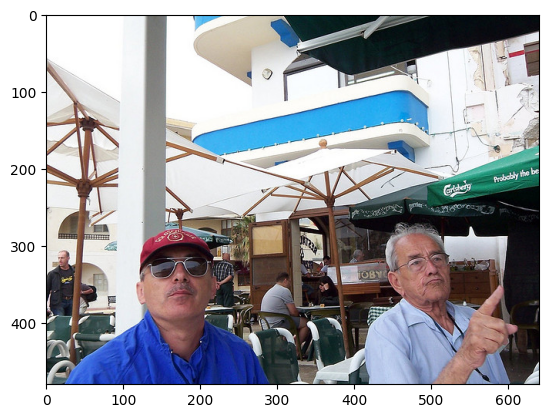

In [123]:
img = train_df['image_path'][20]

print(predict_caption(caption_model, [img], tokenizer,device,max_len))

img1 = plt.imread(img)
plt.imshow(img1)